In [2]:
%load_ext autoreload
%aimport src 

In [3]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from sklearn import metrics

from src import scale_proportional
from src import getOriginFromCropped
from src import binary, otsu, watershed, region_growing
import src.description as description

In [4]:
%autoreload explicit

In [5]:
# !wget -O dataset.zip "https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0" -nc
# !mkdir -p dataset
# !unzip -q dataset.zip -d dataset

In [6]:
# df = pd.read_csv('classifications.csv')
# crop_dataset(df)

In [7]:
df = pd.read_csv('./classifications.csv')
dir_path = './dataset'
test_img = '0a2a5a681410054941cc56f51eb8fbda.png'
df[df['image_filename'] == test_img]

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
5635,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5636,Negative for intraepithelial lesion,1012,875
5636,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5637,Negative for intraepithelial lesion,910,900
5637,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5638,Negative for intraepithelial lesion,1177,416
5638,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5639,Negative for intraepithelial lesion,1254,366
5639,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5640,LSIL,983,450


In [8]:
def crop_image_around_point(image, x, y, crop_size):
    # Calculate the top-left corner of the crop
    x_start = max(0, x - int(crop_size / 2))
    y_start = max(0, y - int(crop_size / 2))

    # Calculate the bottom-right corner of the crop
    x_end = min(image.shape[1], x + int(crop_size / 2))
    y_end = min(image.shape[0], y + int(crop_size / 2))

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    return cropped_image

In [9]:
def crop_with_pil(image, x, y, crop_size):
    lcrop = int(crop_size / 2)
    rcrop = int(crop_size - lcrop)
    width, height = image.size

    # Calculate the top-left corner of the crop
    x_start = max(0, x - lcrop)
    y_start = max(0, y - lcrop)

    # Calculate the bottom-right corner of the crop
    x_end = min(width, x + rcrop)
    y_end = min(height, y + rcrop)

    # Crop the image
    cropped_image = image.crop((x_start, y_start, x_end, y_end))

    return cropped_image

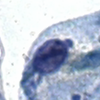

In [10]:
img_path = os.path.join(dir_path, test_img)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_img = crop_image_around_point(image, 1012, 875, 100)
img = Image.fromarray(cropped_img)
img

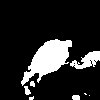

In [11]:
binary = binary(cropped_img, 127, invert=True)
Image.fromarray(binary)

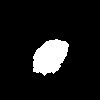

In [12]:
watershed_img = watershed(cropped_img)
Image.fromarray(watershed_img)

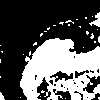

In [13]:
Image.fromarray(otsu(cropped_img, invert=True))

In [14]:
df = pd.read_csv('./main_data.csv')
df = df.drop(df.columns[[0]], axis=1)
df

,image,area,compactness,eccentricity,perimeter,label
0,./cropped_dataset/ASC-H/10.jpg,483,2.066071,0.511844,111.982755,ASC-H
1,./cropped_dataset/ASC-H/10000.jpg,673,2.907563,0.794802,156.811182,ASC-H
2,./cropped_dataset/ASC-H/10001.jpg,970,1.757551,0.497155,146.367531,ASC-H
3,./cropped_dataset/ASC-H/10002.jpg,731,1.570865,0.394551,120.124891,ASC-H
4,./cropped_dataset/ASC-H/10003.jpg,1063,1.394180,0.270889,136.468036,ASC-H
...,...,...,...,...,...,...
11529,./cropped_dataset/Negative for intraepithelial...,470,1.127330,0.478484,81.597979,Negative for intraepithelial lesion
11530,./cropped_dataset/Negative for intraepithelial...,327,1.050396,0.413155,65.698484,Negative for intraepithelial lesion
11531,./cropped_dataset/Negative for intraepithelial...,261,1.027138,0.314594,58.041630,Negative for intraepithelial lesion
11532,./cropped_dataset/Negative for intraepithelial...,835,1.574316,0.643762,128.526911,Negative for intraepithelial lesion


## Scatterplot (6)


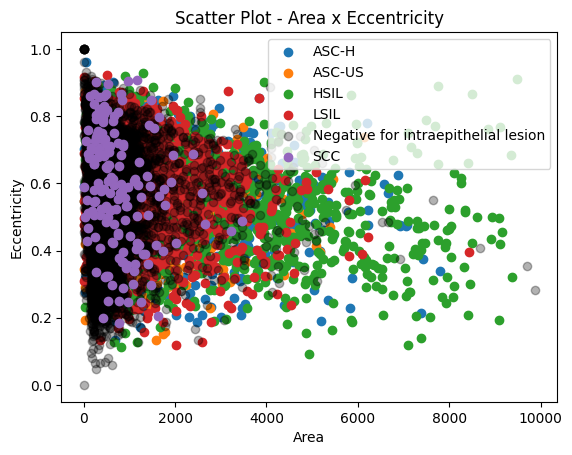

In [15]:
for label in np.unique(df['label']):
    if label == "Negative for intraepithelial lesion":
        plt.scatter(
            df[df['label'] == label]['area'],
            df[df['label'] == label]['eccentricity'],
            alpha=0.3,
            color='#000000',
        )
    else:
        plt.scatter(
            df[df['label'] == label]['area'],
            df[df['label'] == label]['eccentricity'],
            alpha=1,
        )

plt.title('Scatter Plot - Area x Eccentricity')
plt.xlabel('Area')
plt.ylabel('Eccentricity')
plt.legend(np.unique(df['label']))
plt.savefig('./model_data/scatter_all.png')
plt.show()

## Separacao dados (7)


In [16]:
X = df.drop(['label', 'image'], axis=1)  # Features
X['im_id'] = df['image'].apply(lambda p: p.split('/')[-1].split('.')[0])
y = df['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
np.unique(y_train, return_counts=True)[1] / np.unique(y_test, return_counts=True)[1]

array([4.        , 4.00826446, 3.9941349 , 4.        , 3.99926254,
       4.03125   ])

## Mahalanobis (8)


In [18]:
maha_X_train = X_train.drop(columns=['im_id'])
maha_X_test = X_test.drop(columns=['im_id'])

#### Negative x other


In [19]:
np.unique(y_train)

array(['ASC-H', 'ASC-US', 'HSIL', 'LSIL',
       'Negative for intraepithelial lesion', 'SCC'], dtype=object)

In [20]:
target_class = 'Negative for intraepithelial lesion'
mean_class_0 = maha_X_train[y_train == target_class].mean()
mean_class_1 = maha_X_train[y_train != target_class].mean()

covariance_class_0 = np.cov(maha_X_train[y_train == target_class], rowvar=False)
covariance_class_1 = np.cov(maha_X_train[y_train != target_class], rowvar=False)

inv_cov_class_0 = inv(covariance_class_0)
inv_cov_class_1 = inv(covariance_class_1)

In [21]:
mahalanobis_dist_target = np.apply_along_axis(
    lambda x: mahalanobis(x, mean_class_0, inv_cov_class_0), axis=1, arr=maha_X_test
)

mahalanobis_dist_other = np.apply_along_axis(
    lambda x: mahalanobis(x, mean_class_1, inv_cov_class_1), axis=1, arr=maha_X_test
)

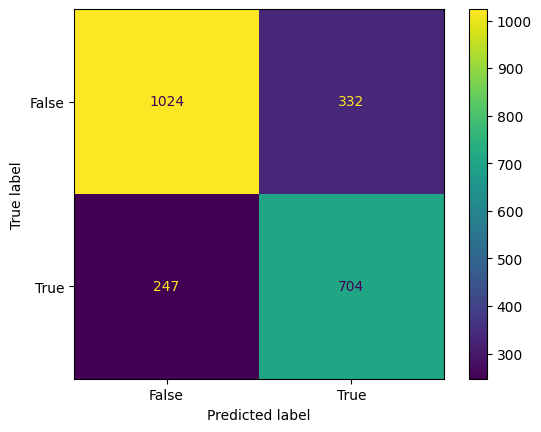

In [22]:
y_pred = np.where(mahalanobis_dist_target < mahalanobis_dist_other, 0, 1)
y_bin_test = np.where(y_test == target_class, 0, 1)

confusion_matrix = metrics.confusion_matrix(y_bin_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=[False, True]
)
cm_display.plot()
plt.show()

#### All classes


In [23]:
class_means = []
class_covariances = []
inv_cov_matrices = []

In [24]:
unique_classes = np.unique(y_train)
for class_label in unique_classes:
    class_data = maha_X_train[y_train == class_label]
    class_means.append(np.mean(class_data, axis=0))
    class_covariances.append(np.cov(class_data, rowvar=False))
    inv_cov_matrices.append(inv(class_covariances[-1]))

In [25]:
mahalanobis_dists = np.zeros((len(maha_X_test), len(unique_classes)))

In [26]:
unique_classes.tolist()

['ASC-H',
 'ASC-US',
 'HSIL',
 'LSIL',
 'Negative for intraepithelial lesion',
 'SCC']

In [27]:
test = [x.to_dict() for x in class_means]
with open("./model_data/mahalanobis/class_means.json", "w") as f:
    json.dump(test, f)

with open("./model_data/mahalanobis/labels.json", "w") as f:
    json.dump(unique_classes.tolist(), f)

test = [(x.tolist()) for x in inv_cov_matrices]
with open("./model_data/mahalanobis/inv_cov_matrices.json", "w") as f:
    json.dump(test, f)

In [28]:
with open("./model_data/mahalanobis/class_means.json", "r") as f:
    class_means = json.load(f)
    class_means = [pd.Series(series_dict) for series_dict in class_means]

with open("./model_data/mahalanobis/labels.json", "r") as f:
    unique_classes = json.load(f)

with open("./model_data/mahalanobis/inv_cov_matrices.json", "r") as f:
    inv_cov_matrices = json.load(f)

In [29]:
for i, class_label in enumerate(unique_classes):
    mahalanobis_dists[:, i] = np.apply_along_axis(
        lambda x: mahalanobis(x, class_means[i], inv_cov_matrices[i]),
        axis=1,
        arr=maha_X_test,
    )

In [30]:
mahalanobis_dists.shape

(2307, 6)

In [31]:
y_pred = np.argmin(mahalanobis_dists, axis=1)
y_pred = list(map(lambda x: unique_classes[x], y_pred))

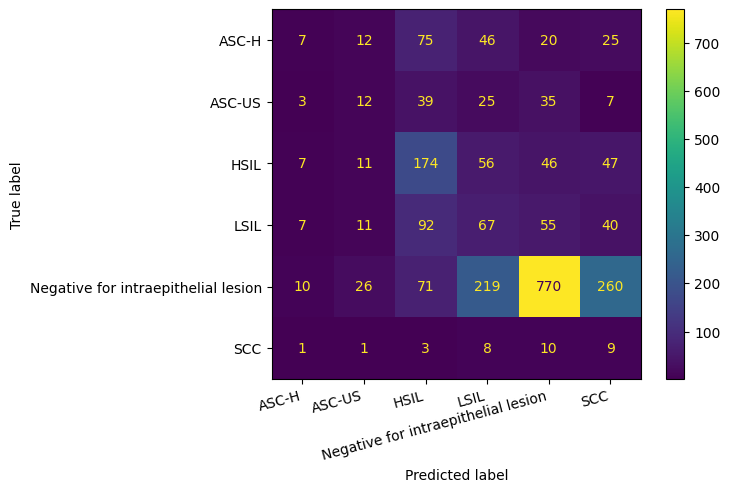

In [32]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=unique_classes
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')
plt.show()

In [33]:
data = (
    description.calculate_area(watershed_img),
    description.calculate_compactness(watershed_img),
    description.calculate_eccentricity(watershed_img),
    description.calculate_perimeter(watershed_img),
)

In [34]:
data

(926, 1.3365537276220156, 0.5641397645686083, 124.71067678928375)

In [35]:
test = np.zeros((1, len(unique_classes))).astype(object)
for i, class_label in enumerate(unique_classes):
    test[:, i] = {class_label: mahalanobis(data, class_means[i], inv_cov_matrices[i])}

In [36]:
for i, key in enumerate(test[0]):
    print(i, key)

0 {'ASC-H': 1.0095576945181999}
1 {'ASC-US': 0.9775457824304495}
2 {'HSIL': 1.0981514278125177}
3 {'LSIL': 0.9135418744389562}
4 {'Negative for intraepithelial lesion': 1.0333296220657857}
5 {'SCC': 1.1995378445642226}


## Rede Neural (9)


In [37]:
import numpy as np
import tensorflow as tf
import glob
from sklearn.preprocessing import LabelEncoder

In [76]:
from keras import Input
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Rescaling,
    BatchNormalization,
)
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet50 import ResNet50

In [39]:
def plot_results(history, show=True):
    hist_df = None
    if hasattr(history, 'history'):
        hist_df = pd.DataFrame(history.history)
    else:
        hist_df = pd.DataFrame(history)
    # hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df) + 1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    if show:
        plt.show()
    else:
        return fig, axs

In [40]:
def get_padding(image, pad_to):
    w, h = image.size
    h_padding = (pad_to - w) / 2
    v_padding = (pad_to - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding + 0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding + 0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding - 0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding - 0.5
    padding = [[int(t_pad), int(b_pad)], [int(l_pad), int(r_pad)], [0, 0]]
    return padding


def pad(img, pad_to=100):
    return tf.pad(
        tf.keras.utils.img_to_array(img, dtype=int),
        get_padding(img, pad_to),
        "CONSTANT",
        0,
    )

### Preparando Datasets

In [41]:
def get_images(root_dir='./cropped_dataset/*', include_ids=None):
    images = []
    labels = []

    for p in glob.glob(os.path.join(root_dir, '*.jpg')):
        label = p.split('\\')[-2]
        if label == 'Negative for intraepithelial lesion':
            label = 'Negative'
        id = p.split('\\')[-1].split('.')[0]
        path = p

        if include_ids is not None:
            if int(id) not in include_ids:
                continue

        im = Image.open(path)
        im = pad(im)
        images.append(im)
        labels.append(label)

    return (np.asarray(images), np.asarray(labels))

In [42]:
# gerando dados de validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)
X_train.shape, X_val.shape

((8304, 5), (923, 5))

In [43]:
X_train_nn, y_train_nn = get_images(include_ids=X_train['im_id'])
X_val_nn, y_val_nn = get_images(include_ids=X_val['im_id'])
X_test_nn, y_test_nn = get_images(include_ids=X_test['im_id'])

In [44]:
label_encoder = LabelEncoder()
y_train_all_classes = label_encoder.fit_transform(y_train_nn)
y_val_all_classes = label_encoder.transform(y_val_nn)
y_test_all_classes = label_encoder.transform(y_test_nn)

y_train_nn_ispos = np.where(y_train_nn != 'Negative', 1, 0)
y_val_nn_ispos = np.where(y_val_nn != 'Negative', 1, 0)
y_test_nn_ispos = np.where(y_test_nn != 'Negative', 1, 0)

In [45]:
train_ds_all = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_all_classes))
val_ds_all = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_all_classes))
test_ds_all = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_all_classes))

train_ds_pos = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn_ispos))
val_ds_pos = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_nn_ispos))
test_ds_pos = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_nn_ispos))

In [46]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 8196

train_data_all = train_ds_all.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data_all = val_ds_all.batch(BATCH_SIZE)
test_data_all = test_ds_all.batch(BATCH_SIZE)

train_data_pos = train_ds_pos.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data_pos = val_ds_pos.batch(BATCH_SIZE)
test_data_pos = test_ds_pos.batch(BATCH_SIZE)

### Modelo Baseline

#### Pos x Neg

In [62]:
pos_model = tf.keras.models.load_model(
    '.\\model_data\\nn\\baseline\\posxneg\\model.keras'
)
pos_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_13 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_39 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 47, 47, 32)        184

In [ ]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
conv = Conv2D(64, (3, 3), activation='relu')(preprocess)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(32, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(16, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
global_pool = GlobalAveragePooling2D()(pool)
hidden1 = Dense(64, activation='relu')(global_pool)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

pos_model = tf.keras.Model(inputs=input, outputs=output)
pos_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_27 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 32)        1846

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

pos_model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_model.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

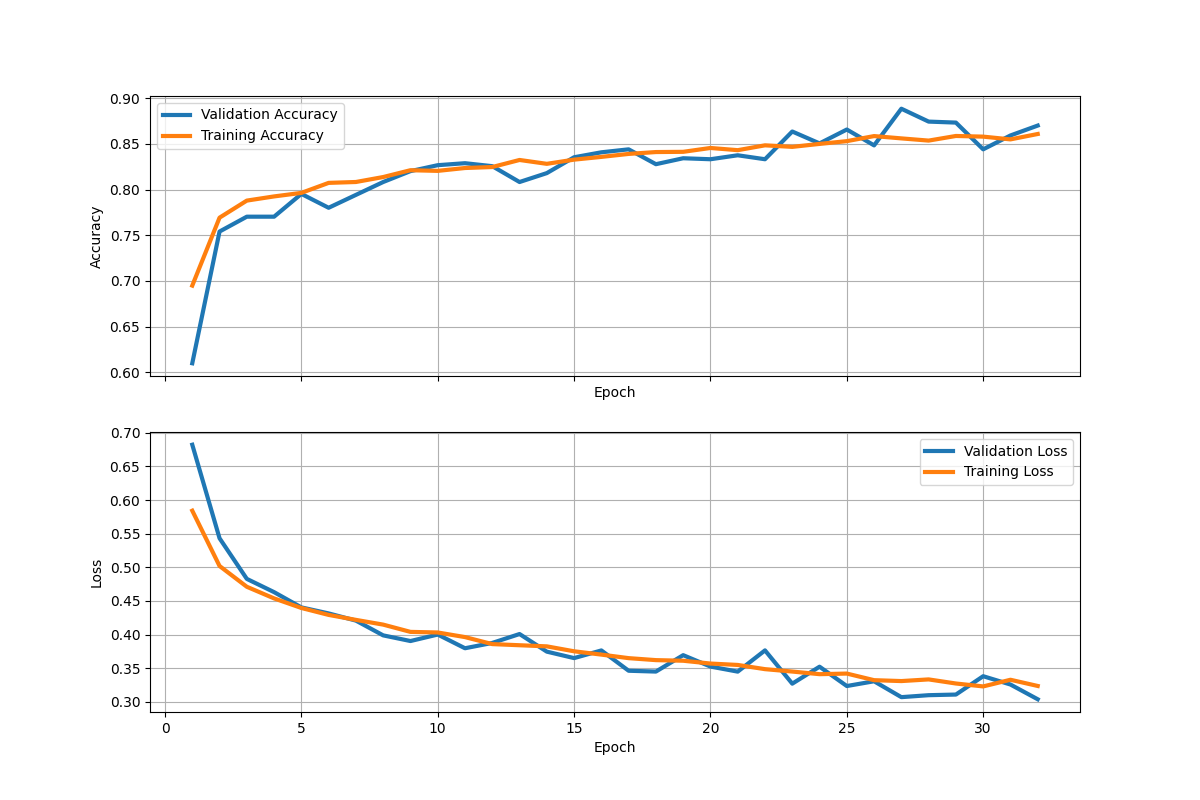

In [ ]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\baseline\\posxneg\\graph.png')
plt.show()

73/73 [==============================] - 2s 28ms/step


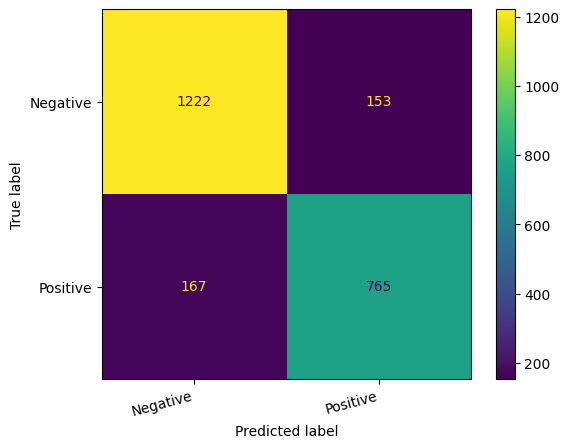

In [ ]:
y_pred = np.where(pos_model.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\baseline\\posxneg\\confusion_matrix.png')
plt.show()

In [ ]:
pos_model.evaluate(test_data_pos)

73/73 [==============================] - 3s 26ms/step - loss: 0.3251 - accuracy: 0.8613


[0.3251415193080902, 0.8612917065620422]

In [ ]:
all_model.save('.\\model_data\\nn\\baseline\\posxneg\\model.keras')

#### All Classes

In [65]:
all_model = tf.keras.models.load_model(
    '.\\model_data\\nn\\baseline\\all_classes\\model.keras'
)
all_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_48 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 47, 47, 32)        184

In [154]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
conv = Conv2D(64, (3, 3), activation='relu')(preprocess)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(32, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(16, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
global_pool = GlobalAveragePooling2D()(pool)
hidden1 = Dense(64, activation='relu')(global_pool)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(6, activation='softmax')(hidden2)

all_model = tf.keras.Model(inputs=input, outputs=output)
all_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_27 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 32)        1846

In [114]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

all_model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_model.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

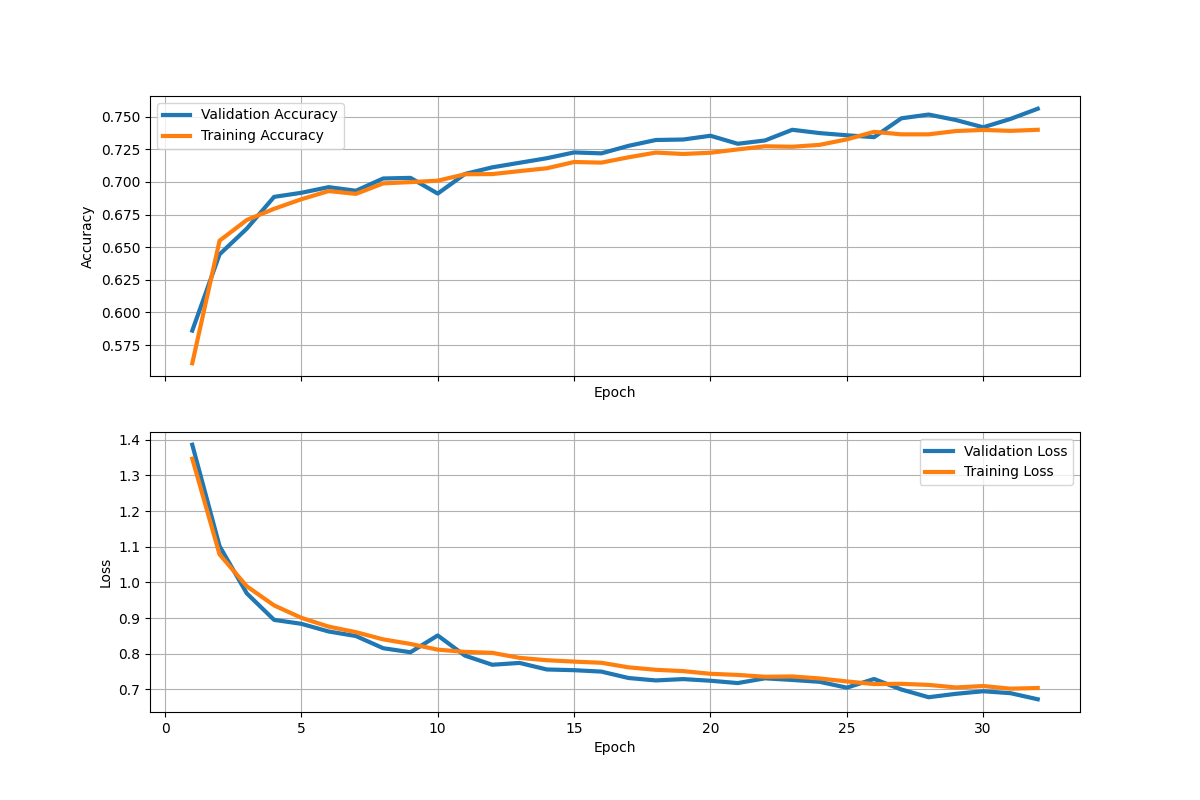

In [66]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\baseline\\all_classes\\graph.png')
plt.show()

 3/73 [>.............................] - ETA: 4s

73/73 [==============================] - 2s 28ms/step


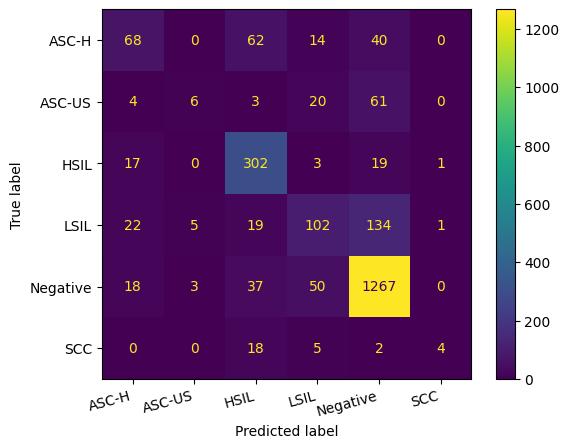

In [69]:
y_pred = np.argmax(all_model.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)


cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\baseline\\all_classes\\confusion_matrix.png')
plt.show()

In [70]:
all_model.evaluate(test_data_all)

73/73 [==============================] - 3s 34ms/step - loss: 0.6769 - accuracy: 0.7581


[0.6769126057624817, 0.7581274509429932]

In [59]:
all_model.save('.\\model_data\\nn\\baseline\\all_classes\\model.keras')

### Modelo Resnet

#### Pos x Neg

In [94]:
pos_resnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\resnet\\posxneg\\model.keras'
)
pos_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [91]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
resnet = ResNet50(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(resnet.output)
output = Dense(1, activation='sigmoid')(global_pool)

pos_resnet = tf.keras.Model(inputs=input, outputs=output)
pos_resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 100, 100, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling_3[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']        

In [92]:
# number of layers that will be trained
trainable_layers = len(pos_resnet.layers)/5

for i, l in enumerate(pos_resnet.layers):
    if len(pos_model.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

pos_resnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_resnet.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

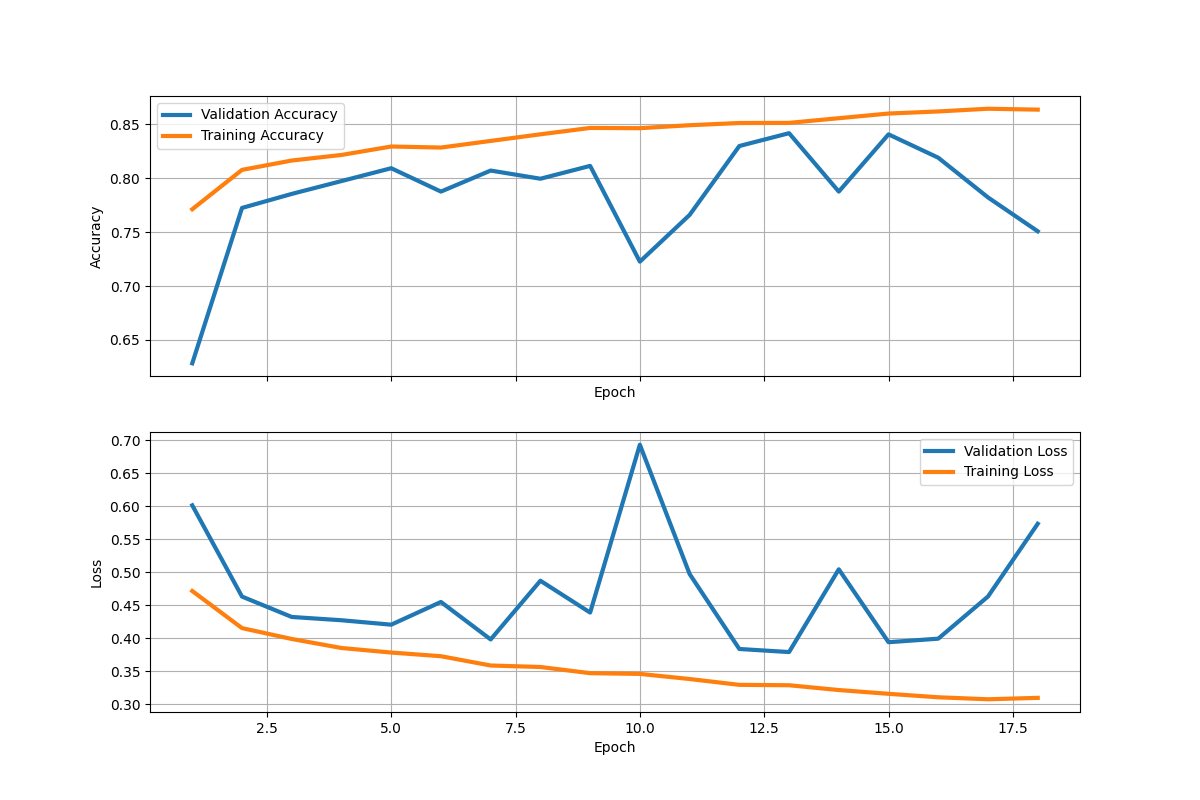

In [81]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\resnet\\posxneg\\graph.png')
plt.show()

73/73 [==============================] - 12s 135ms/step


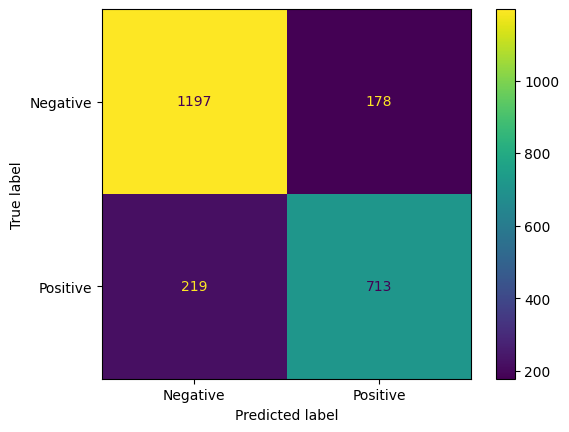

In [95]:
y_pred = np.where(pos_resnet.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
# plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\resnet\\posxneg\\confusion_matrix.png')
plt.show()

In [83]:
pos_resnet.evaluate(test_data_pos)

73/73 [==============================] - 13s 142ms/step - loss: 0.3960 - accuracy: 0.8279


[0.39599233865737915, 0.8279150128364563]

In [ ]:
pos_resnet.save('.\\model_data\\nn\\resnet\\posxneg\\model.keras')

#### All Classes

In [99]:
all_resnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\resnet\\all_classes\\model.keras'
)
all_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [96]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
resnet = ResNet50(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(resnet.output)
output = Dense(6, activation='softmax')(global_pool)

all_resnet = tf.keras.Model(inputs=input, outputs=output)
all_resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 100, 100, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling_4[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']        

In [97]:
# number of layers that will be trained
trainable_layers = len(all_resnet.layers) / 6

for i, l in enumerate(all_resnet.layers):
    if len(all_resnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

In [ ]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

all_resnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_resnet.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

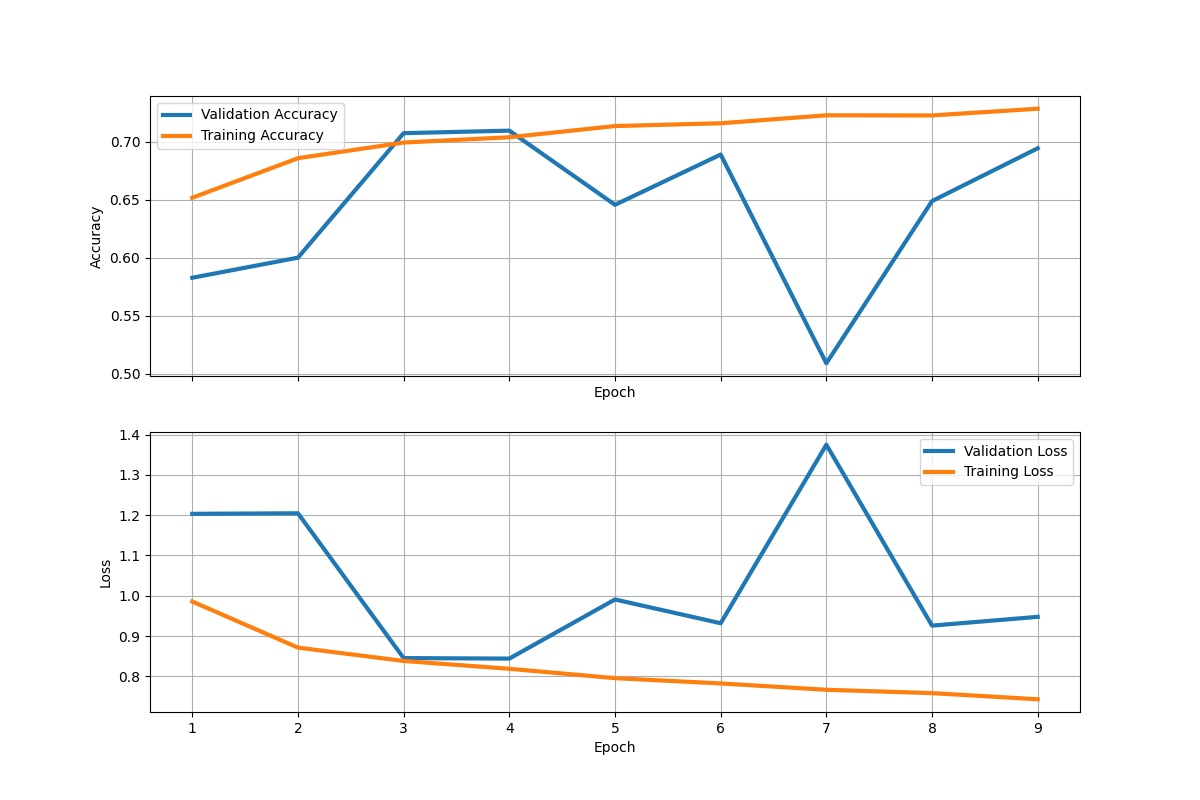

In [100]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\resnet\\all_classes\\graph.png')
plt.show()

73/73 [==============================] - 12s 137ms/step


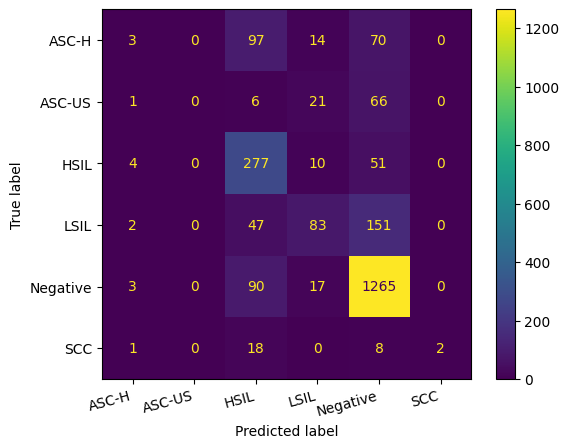

In [101]:
y_pred = np.argmax(all_resnet.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\baseline\\all_classes\\confusion_matrix.png')
plt.show()

In [102]:
all_resnet.evaluate(test_data_all)

73/73 [==============================] - 13s 138ms/step - loss: 0.8267 - accuracy: 0.7065


[0.8266584873199463, 0.7065452933311462]

In [ ]:
all_resnet.save('.\\model_data\\nn\\resnet\\all_classes\\model.keras')